In [2]:
from scipy import *
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

from Lib.LinearAlgebraFunctions import *
from Lib.Parametrs import *

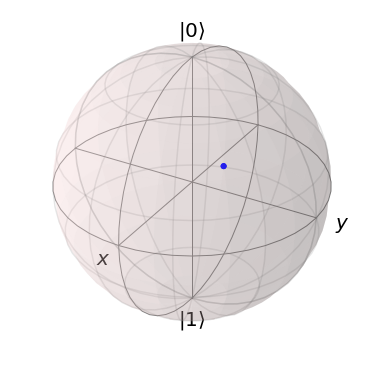

In [3]:
b = qt.Bloch()
pnt = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]

b.add_points(pnt)

b.show()